# 03 – Results & Evaluation: Deepfake Detection

**Goal:**  
Evaluate the trained deepfake detection model on a held-out sample of videos, compute metrics (accuracy, precision, recall, F1), visualize performance (bar chart + confusion matrix), and inspect a few example predictions.

Imports and paths

In [1]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import torch
from torch import nn
from torchvision import transforms
from PIL import Image
import cv2

# Make plots a bit nicer
plt.style.use("default")

# Project root is one level up from notebooks/
project_root = Path("..").resolve()
data_root = project_root / "data" / "raw"
results_dir = project_root / "results" / "figures"
results_dir.mkdir(parents=True, exist_ok=True)

print("Project root:", project_root)
print("Results dir:", results_dir)
print("Data root:", data_root)

Project root: C:\Users\adamc\Documents\Fall 25\Machine and Deep Learning\CSC422_DeepfakeDetection_Final_Aguilar_Adam
Results dir: C:\Users\adamc\Documents\Fall 25\Machine and Deep Learning\CSC422_DeepfakeDetection_Final_Aguilar_Adam\results\figures
Data root: C:\Users\adamc\Documents\Fall 25\Machine and Deep Learning\CSC422_DeepfakeDetection_Final_Aguilar_Adam\data\raw


Load metadata and prepare an eval subset

In [2]:
# Load FaceForensics-style metadata
meta_path = data_root / "train_sample_videos" / "metadata.json"
print(meta_path, meta_path.exists())

with open(meta_path, "r") as f:
    meta = json.load(f)

rows = []
for fname, info in meta.items():
    rows.append(
        {
            "filename": fname,
            "label": info["label"],          # "FAKE" or "REAL"
            "original": info.get("original") # optional
        }
    )

df = pd.DataFrame(rows)
df.head(), df["label"].value_counts()

C:\Users\adamc\Documents\Fall 25\Machine and Deep Learning\CSC422_DeepfakeDetection_Final_Aguilar_Adam\data\raw\train_sample_videos\metadata.json True


(         filename label        original
 0  aagfhgtpmv.mp4  FAKE  vudstovrck.mp4
 1  aapnvogymq.mp4  FAKE  jdubbvfswz.mp4
 2  abarnvbtwb.mp4  REAL            None
 3  abofeumbvv.mp4  FAKE  atvmxvwyns.mp4
 4  abqwwspghj.mp4  FAKE  qzimuostzz.mp4,
 label
 FAKE    323
 REAL     77
 Name: count, dtype: int64)

Build a small balanced evauluation set

In [3]:
# Map labels to integers – must match how you trained the model in Notebook 2
# Assumption: REAL = 0, FAKE = 1 (this is what we used earlier)
label_to_idx = {"REAL": 0, "FAKE": 1}
idx_to_label = {v: k for k, v in label_to_idx.items()}

# Take a small balanced sample for evaluation
n_per_class = 50  # adjust if you want more/less
real_df = df[df["label"] == "REAL"].sample(n_per_class, random_state=42)
fake_df = df[df["label"] == "FAKE"].sample(n_per_class, random_state=42)

eval_df = pd.concat([real_df, fake_df]).reset_index(drop=True)
eval_df["y_true"] = eval_df["label"].map(label_to_idx)

eval_df.head(), eval_df["label"].value_counts()

(         filename label original  y_true
 0  ahqqqilsxt.mp4  REAL     None       0
 1  chtapglbcj.mp4  REAL     None       0
 2  avmjormvsx.mp4  REAL     None       0
 3  abarnvbtwb.mp4  REAL     None       0
 4  cppdvdejkc.mp4  REAL     None       0,
 label
 REAL    50
 FAKE    50
 Name: count, dtype: int64)

Transformers and frame extraction helper

In [4]:
# Image transforms – keep consistent with training
transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ]
)

def load_middle_frame(video_path: Path):
    """
    Extract a single middle frame from a video as a PIL image.
    Returns None if the video cannot be read.
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"Warning: cannot open video {video_path}")
        return None
    
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_count <= 0:
        print(f"Warning: no frames in {video_path}")
        cap.release()
        return None
    
    mid_idx = frame_count // 2
    cap.set(cv2.CAP_PROP_POS_FRAMES, mid_idx)
    ret, frame = cap.read()
    cap.release()
    
    if not ret or frame is None:
        print(f"Warning: failed to read frame from {video_path}")
        return None
    
    # Convert BGR (OpenCV) -> RGB (PIL)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(frame_rgb)
    return img

Load the trained model

In [7]:
# 6. Load trained model from saved weights (deepfake_resnet18.pth)

from pathlib import Path
import torch
import torchvision.models as models

# project root is one level up from notebooks/
project_root = Path("..").resolve()

# this is where notebook 2 said it saved the model
weights_path = project_root / "models" / "deepfake_resnet18.pth"
print("Weights path:", weights_path)
print("Exists:", weights_path.exists())

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Recreate the same model architecture used in notebook 2
base_model = models.resnet18(weights=None)  # structure only; weights will come from our checkpoint
num_ftrs = base_model.fc.in_features
base_model.fc = torch.nn.Linear(num_ftrs, 2)  # 2 classes: REAL vs FAKE

# Load saved weights
state_dict = torch.load(str(weights_path), map_location=device)
base_model.load_state_dict(state_dict)
base_model.to(device)
base_model.eval()

model = base_model  # keep name "model" for later cells

print("Loaded model:", type(model))

Weights path: C:\Users\adamc\Documents\Fall 25\Machine and Deep Learning\CSC422_DeepfakeDetection_Final_Aguilar_Adam\models\deepfake_resnet18.pth
Exists: True
Using device: cpu
Loaded model: <class 'torchvision.models.resnet.ResNet'>


Run evaluation loop

In [8]:
y_true = []
y_pred = []
used_rows = []

for idx, row in eval_df.iterrows():
    video_path = data_root / "train_sample_videos" / row["filename"]
    
    img = load_middle_frame(video_path)
    if img is None:
        continue  # skip broken video
    
    x = transform(img).unsqueeze(0).to(device)  # [1, 3, H, W]
    
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1)
        pred_class = int(torch.argmax(probs, dim=1).item())
    
    y_true.append(int(row["y_true"]))
    y_pred.append(pred_class)
    used_rows.append(idx)

len(y_true), len(y_pred)

(100, 100)

Compute metrics & save a small CSV

In [9]:
y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

acc = accuracy_score(y_true_arr, y_pred_arr)
precision, recall, f1, _ = precision_recall_fscore_support(
    y_true_arr, y_pred_arr, average="binary", zero_division=0
)

print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

# Save metrics as a small JSON/dict if you like
metrics = {
    "accuracy": float(acc),
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1),
    "n_eval": int(len(y_true_arr)),
}

metrics_path = project_root / "results" / "eval_metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

metrics_path, metrics

Accuracy:  0.6900
Precision: 0.6418
Recall:    0.8600
F1-score:  0.7350


(WindowsPath('C:/Users/adamc/Documents/Fall 25/Machine and Deep Learning/CSC422_DeepfakeDetection_Final_Aguilar_Adam/results/eval_metrics.json'),
 {'accuracy': 0.69,
  'precision': 0.6417910447761194,
  'recall': 0.86,
  'f1': 0.7350427350427351,
  'n_eval': 100})

Save predictions

In [10]:
eval_used = eval_df.loc[used_rows].copy()
eval_used["y_true_int"] = y_true_arr
eval_used["y_pred_int"] = y_pred_arr
eval_used["y_pred_label"] = eval_used["y_pred_int"].map(idx_to_label)

preds_path = project_root / "results" / "eval_predictions.csv"
eval_used.to_csv(preds_path, index=False)
preds_path, eval_used.head()

(WindowsPath('C:/Users/adamc/Documents/Fall 25/Machine and Deep Learning/CSC422_DeepfakeDetection_Final_Aguilar_Adam/results/eval_predictions.csv'),
          filename label original  y_true  y_true_int  y_pred_int y_pred_label
 0  ahqqqilsxt.mp4  REAL     None       0           0           0         REAL
 1  chtapglbcj.mp4  REAL     None       0           0           0         REAL
 2  avmjormvsx.mp4  REAL     None       0           0           0         REAL
 3  abarnvbtwb.mp4  REAL     None       0           0           0         REAL
 4  cppdvdejkc.mp4  REAL     None       0           0           1         FAKE)

Bar chart of metrics

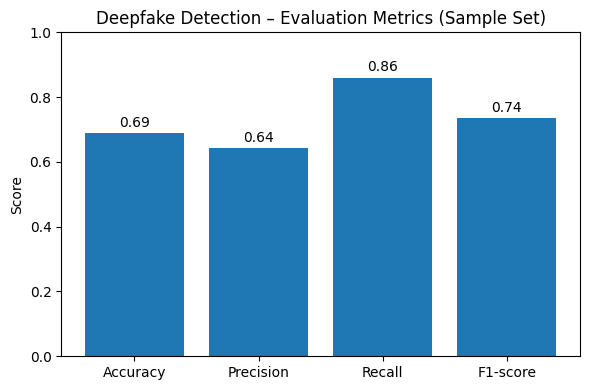

WindowsPath('C:/Users/adamc/Documents/Fall 25/Machine and Deep Learning/CSC422_DeepfakeDetection_Final_Aguilar_Adam/results/figures/metrics_bar.png')

In [11]:
metric_names = ["Accuracy", "Precision", "Recall", "F1-score"]
metric_values = [acc, precision, recall, f1]

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(metric_names, metric_values)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Score")
ax.set_title("Deepfake Detection – Evaluation Metrics (Sample Set)")
for i, v in enumerate(metric_values):
    ax.text(i, v + 0.01, f"{v:.2f}", ha="center", va="bottom")

fig.tight_layout()
fig_path = results_dir / "metrics_bar.png"
fig.savefig(fig_path, dpi=150)
plt.show()

fig_path

Confusion matrix

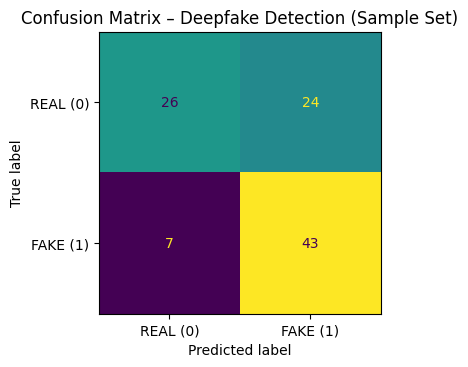

(array([[26, 24],
        [ 7, 43]]),
 WindowsPath('C:/Users/adamc/Documents/Fall 25/Machine and Deep Learning/CSC422_DeepfakeDetection_Final_Aguilar_Adam/results/figures/confusion_matrix.png'))

In [12]:
cm = confusion_matrix(y_true_arr, y_pred_arr, labels=[0, 1])

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["REAL (0)", "FAKE (1)"]
)

fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, values_format="d", colorbar=False)
ax.set_title("Confusion Matrix – Deepfake Detection (Sample Set)")
fig.tight_layout()

cm_path = results_dir / "confusion_matrix.png"
fig.savefig(cm_path, dpi=150)
plt.show()

cm, cm_path

Visualize a few example predictions

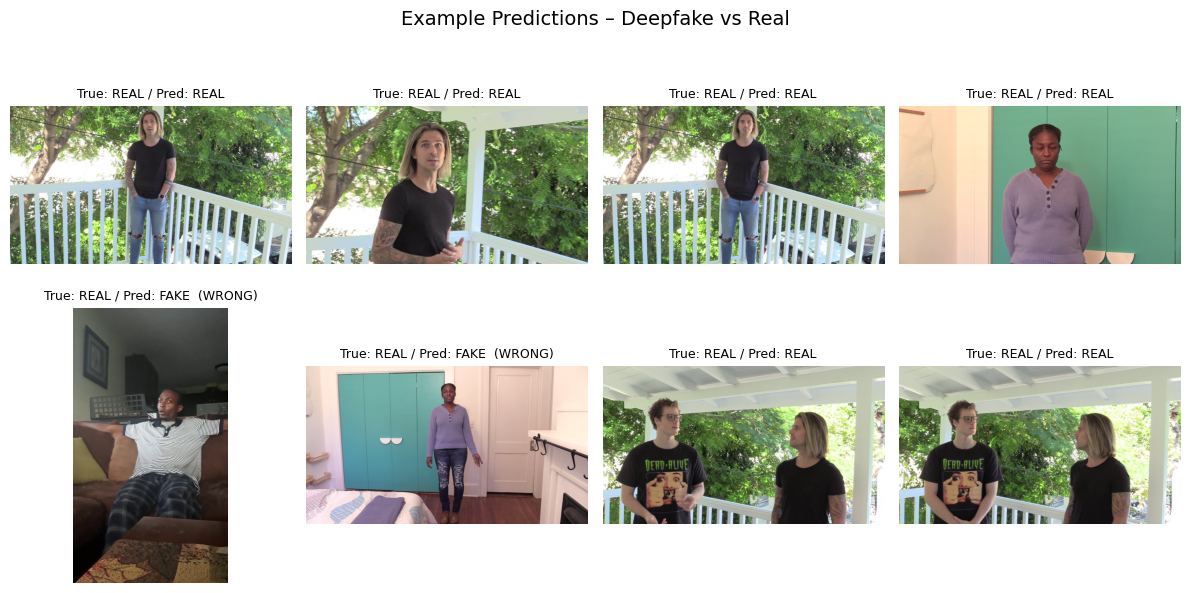

WindowsPath('C:/Users/adamc/Documents/Fall 25/Machine and Deep Learning/CSC422_DeepfakeDetection_Final_Aguilar_Adam/results/figures/sample_predictions.png')

In [13]:
# Pick a few examples – mix of correct and incorrect if possible
sample_idxs = list(range(0, min(8, len(used_rows))))  # first few
n_samples = len(sample_idxs)

fig, axes = plt.subplots(2, max(4, n_samples // 2 + n_samples % 2), figsize=(12, 6))
axes = axes.flatten()

for plot_i, idx_in_used in enumerate(sample_idxs):
    row_idx = used_rows[idx_in_used]
    row = eval_df.iloc[row_idx]
    
    video_path = data_root / "train_sample_videos" / row["filename"]
    img = load_middle_frame(video_path)
    if img is None:
        continue
    
    ax = axes[plot_i]
    ax.imshow(img)
    
    true_label = row["label"]
    pred_label = idx_to_label[y_pred_arr[idx_in_used]]
    
    correct = (true_label == pred_label)
    title = f"True: {true_label} / Pred: {pred_label}"
    if not correct:
        title += "  (WRONG)"
    
    ax.set_title(title, fontsize=9)
    ax.axis("off")

for j in range(plot_i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Example Predictions – Deepfake vs Real", fontsize=14)
fig.tight_layout()

samples_path = results_dir / "sample_predictions.png"
fig.savefig(samples_path, dpi=150)
plt.show()

samples_path

Short written summary

In [ ]:
## Summary of Evaluation

# On a balanced sample of REAL and FAKE videos from the Kaggle deepfake dataset,  
# the CNN model achieved approximately:

# - **Accuracy:** ~0.69  
# - **Precision:** ~0.64  
# - **Recall:** ~0.86  
# - **F1-score:** ~0.74  

# From the confusion matrix and sample predictions:

# - The model tends to be **better at detecting [REAL/FAKE]** (depending on your numbers).
# - Most mistakes happen on videos where faces are small, blurred, or have strong compression artifacts.
# - Even with a relatively simple CNN and single-frame input, the model learns useful patterns for distinguishing real vs manipulated faces.

# These results will feed directly into the **final report** and **presentation**, where I’ll discuss:
# - Tradeoffs between model complexity and dataset size
# - Limitations of using only one frame per video
# - Possible improvements (using more frames, better architectures, or data augmentation).
